In [1]:
# save model checkpoints, run on HPC

# notes
# replace cnn with capsule?
# do i need to standardize images (and how) or is normalised (as is) fine?
# ultimately replace pen with myosuite finger to make it a finger painting task - could have flexion/extension determine finger up/down
# setting initial states to zero means there is no gradient for top layer alphas (and the parameters they depend on) on time 1 - could add eps?
# infer covariances - cholesky (softmax induces covariances in alphas, not z's).

# pen_xy0 options: always start in center of canvas (105/2, 105/2), randomise and use extra feature dimension in image, let the CNN choose
# consider learning initial neural states
# add control costs? e.g. squared velocity costs?
# replace your softmaxes with nn.softmax??? etc
# add batch norm and other tricks to CNN, dropout?

# if there are l layers (e.g. 3), the top-layer alphas on the last l-1 time steps (e.g. 2) don't influence the state of the lowest layer and hence the objective
# when n_layer = 3, top-layer alphas at time 1 inlfuence the state of the lowest layer and hence the objective at time 3, and so on
# this leads to zeros in the biases and columns of weight matrix in last dense layer

# relu activation function, and to some extent binary image data, can lead to zero gradients scattered throughout CNN
# these gradients go to zero if you change relu to tanh and make data continuous on [0, 1], so not pathological, i don't think

# # use xeus-python kernel; Python 3.9 (XPython)
# from jax.config import config
# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)
# breakpoint()
# typing help gives you list of available commands

# print values without tracer information
# jax.debug.print("{z_mean}", z_mean = z_mean)
# jax.debug.breakpoint() - didn't work for me

# convert to python file
# jupyter nbconvert --to python notebook.ipynb

import jax
from jax import random, lax, jit, vmap, value_and_grad
from jax.tree_util import tree_map
from jax.nn import initializers # https://jax.readthedocs.pio/en/latest/jax.nn.initializers.html
import jax.numpy as np
import numpy as onp
from flax import linen as nn
import optax

import time
from copy import copy

from flax.training import checkpoints
import orbax.checkpoint as orbax

# from torch.utils.tensorboard import SummaryWriter

In [2]:
class CNN(nn.Module):
    n_loops_top_layer: int
    x_dim_top_layer: int

    @nn.compact
    def __call__(self, x):
        
        # deepmimic
        # x = nn.Conv(features = 16, kernel_size = (8, 8))(x)
        # x = nn.relu(x)
        # x = nn.Conv(features = 32, kernel_size = (4, 4))(x)
        # x = nn.relu(x)
        # x = nn.Conv(features = 32, kernel_size = (4, 4))(x)
        # x = nn.relu(x)
        # x = x.reshape((x.shape[0], -1)) # flatten
        # x = nn.Dense(features = 64)(x)
        # x = nn.relu(x)
        # x = nn.Dense(features = 1024)(x)
        # x = nn.relu(x)
        # x = nn.Dense(features = 512)(x)
        # x = nn.relu(x)
        # x = nn.Dense(features = (self.n_loops_top_layer + self.x_dim_top_layer) * 2)(x)
        
        # End-to-End Training of Deep Visuomotor Policies
        x = nn.Conv(features = 64, kernel_size = (7, 7))(x)
        x = nn.relu(x)
        x = nn.Conv(features = 32, kernel_size = (5, 5))(x)
        x = nn.relu(x)
        x = nn.Conv(features = 32, kernel_size = (5, 5))(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1)) # flatten
        x = nn.Dense(features = 64)(x)
        x = nn.relu(x)
        x = nn.Dense(features = 40)(x)
        x = nn.relu(x)
        x = nn.Dense(features = 40)(x)
        x = nn.relu(x)
        x = nn.Dense(features = (self.n_loops_top_layer + self.x_dim_top_layer) * 2)(x)

        # mean and log variances of Gaussian distribution over latents
        z_mean, z_log_var = np.split(x, 2, axis = 1)
        
        # sample the latents
        z = diag_Gaussian_sample(z_mean, z_log_var, hyperparams, key)
    
        # split into latents that determine the top-layer alphas (z1) and initial state (z2)
        z1, z2 = np.split(z, [self.n_loops_top_layer], axis = 1)
        
        return z_mean, z_log_var, z1, np.squeeze(z2)
    
class pen_actions_readout(nn.Module):

    @nn.compact
    def __call__(self, x):
        
        # linear layer
        outputs = nn.Dense(3)(x)

        # pen velocity in x and y directions
        d_xy = outputs[:2]

        # log probability that the pen is down (actively drawing)
        pen_down_log_p = nn.log_sigmoid(outputs[2])
    
        return d_xy, pen_down_log_p
    
def update_pen_position(pen_xy, d_xy, hyperparams):
    
    # candidate new pen position
    pen_xy = pen_xy + d_xy
    
    # align pen position relative to centre of canvas
    pen_xy = pen_xy - hyperparams['image_dim'] / 2
    
    # transform canvas boundaries to -/+ 5
    pen_xy = pen_xy * 2 / hyperparams['image_dim'] * 5
    
    # squash pen position to be within canvas boundaries
    pen_xy = nn.sigmoid(pen_xy)
    
    # transform canvas boundaries back to their original values
    pen_xy_new = pen_xy * hyperparams['image_dim']
    
    return pen_xy_new

def smooth_max(x, hyperparams):
    
    return np.exp(log_sum_exp(x * hyperparams['smooth_max_parameter'], x) -
                  log_sum_exp(x * hyperparams['smooth_max_parameter'], 1))

def softmax(x, temperature):
    
    return np.exp(x / temperature - log_sum_exp(x / temperature, 1))

def log_sum_exp(x, w):
    """
    log-sum-exp trick for numerical stability
    w can be used to perform a weighted sum
    """
    m = np.max(x, axis = 0)

    return np.log(np.sum(w * np.exp(x - m), axis = 0)) + m

def decode_one_step(params, hyperparams, models, A, state, inputs):
    
    x, pen_xy = state
    
    top_layer_alphas = inputs
    
    # compute the alphas
    alphas = jax.tree_map(lambda W, x, b, t: softmax(W @ x + b, t), params['dynamics']['W_a'], x[:2], params['dynamics']['b'], 
                          params['dynamics']['t'][1:])
    
    # prepend the top-layer alphas
    alphas.insert(0, top_layer_alphas)

    # compute the additive inputs
    u = jax.tree_map(lambda W, x: W @ x, params['dynamics']['W_u'], x[:2])
    
    # prepend the top-layer additive inputs
    u.insert(0, x[0] * 0)

    # update the states
    x_new = jax.tree_map(lambda A, x, alphas, u: x + (np.sum(alphas[:, None, None] * A, axis = 0) @ x + u) * hyperparams['dt'], A, x, alphas, u)

    # readout the pen actions (pen velocity and pen down probability) from the state at the bottom layer
    _, readout = models
    d_xy, pen_down_log_p = readout.apply(params['readout'], x = x_new[-1])
    
    # calculate the per-pixel bernoulli parameter
    p_xy = per_pixel_bernoulli_parameter(params, hyperparams, pen_xy, pen_down_log_p)
    
    # update the pen position based on the pen velocity
    pen_xy_new = update_pen_position(pen_xy, d_xy, hyperparams)

    state = x_new, pen_xy_new
    outputs = alphas, x_new, pen_xy_new, p_xy, pen_down_log_p
    
    return state, outputs
    
def encode_decode(params, hyperparams, models, data, A, x0, T, key):
    
    encoder, _ = models

    z_mean, z_log_var, z1, z2 = encoder.apply(params['encoder'], x = data[None,:,:,None])
    
    top_layer_alphas = softmax(z1.T, params['dynamics']['t'][0])

    x0[0] = z2
    
    pen_xy0 = hyperparams['image_dim'] / 2 # initialise pen in centre of canvas

    decoder = lambda state, inputs: decode_one_step(params, hyperparams, models, A, state = state, inputs = inputs)
    _, (alphas, x, pen_xy, p_xy_t, pen_down_log_p) = lax.scan(decoder, (x0, pen_xy0), np.repeat(top_layer_alphas.T, T, axis = 0))

    return {'z_mean': z_mean, 
            'z_log_var': z_log_var,
            'alphas': alphas,
            'x0': x0,
            'x': x,
            'pen_xy0': pen_xy0,
            'pen_xy': pen_xy,
            'p_xy_t': p_xy_t,
            'pen_down_log_p': pen_down_log_p}
    
def dynamical_VAE(params, hyperparams, models, data, A, x0, T, key):
    
    key, subkeys = keyGen(key, n_subkeys = 1)
    
    results = encode_decode(params, hyperparams, models, data, A, x0, T, next(subkeys))
    
    return results

batch_dynamical_VAE = vmap(dynamical_VAE, in_axes = (None, None, None, 0, None, None, None, 0))
    
def losses(params, hyperparams, models, data, x0, T, kl_weight, key):

    # construct the dynamics matrices A from the model parameters
    A = construct_dynamics_matrix(params, hyperparams)

    # pass the data through the VAE
    n_examples = data.shape[0]
    subkeys = random.split(key, n_examples)
    results = batch_dynamical_VAE(params, hyperparams, models, data, A, x0, T, subkeys)

    # cross entropy given latent variables
    cross_entropy = np.mean(batch_cross_entropy_loss(params, hyperparams, results['p_xy_t'], data))
    
    # KL divergence between the approximate posterior and prior over the latents
    mu_0 = 0
    log_var_0 = params['prior_z_log_var']
    mu_1 = results['z_mean']
    log_var_1 = results['z_log_var']
    kl_loss_z_prescale = np.mean(batch_KL_diagonal_Gaussians(mu_0, log_var_0, mu_1, log_var_1, hyperparams))
    kl_loss_z = kl_weight * kl_loss_z_prescale
    
    loss = cross_entropy + kl_loss_z
    
    all_losses = {'total': loss, 'cross_entropy': cross_entropy, 'kl_z': kl_loss_z, 'kl_z_prescale': kl_loss_z_prescale}
    
    return loss, all_losses

losses_jit = jit(losses, static_argnums = (2, 5))
training_loss_grad = value_and_grad(losses_jit, has_aux = True)

def construct_dynamics_matrix(params, hyperparams):
    
    # positive semi-definite matrix P
    P = jax.tree_map(lambda P: P @ P.T, params['dynamics']['P'])

    # skew symmetric matrix S
    S = jax.tree_map(lambda U, V: U @ np.transpose(V, (0, 2, 1)) - V @ np.transpose(U, (0, 2, 1)), 
                     params['dynamics']['S_U'], params['dynamics']['S_V'])

    # dynamics matrix A (loops organised along axis 0)
    A = jax.tree_map(lambda L, S, P: (-L @ np.transpose(L, (0, 2, 1)) + S) @ P, params['dynamics']['L'], S, P)

    return A

def stabilise_varance(log_var, hyperparams):
    """
    var_min is added to the variances for numerical stability
    """
    return np.log(np.exp(log_var) + hyperparams['var_min'])

def diag_Gaussian_sample(mean, log_var, hyperparams, key):
    """
    sample from a diagonal Gaussian distribution
    """
    log_var = stabilise_varance(log_var, hyperparams)
    
    return mean + np.exp(0.5 * log_var) * random.normal(key, mean.shape)

def log_Gaussian_kernel(x, mu, log_var, hyperparams):
    """
    calculate the log likelihood of x under a diagonal Gaussian distribution
    """
    log_var = stabilise_varance(log_var, hyperparams)
    
    return -0.5 * (x - mu)**2 / np.exp(log_var)

def log_likelihood_diagonal_Gaussian(x, mu, log_var, hyperparams):
    """
    calculate the log likelihood of x under a diagonal Gaussian distribution
    """
    log_var = stabilise_varance(log_var, hyperparams)
    
    return np.sum(-0.5 * (log_var + np.log(2 * np.pi) + (x - mu)**2 / np.exp(log_var)))

def per_pixel_bernoulli_parameter(params, hyperparams, pen_xy, pen_down_log_p):
    
    ll_p_x = log_Gaussian_kernel(pen_xy[0], hyperparams['x_pixels'], params['pen_log_var'], hyperparams)
    ll_p_y = log_Gaussian_kernel(pen_xy[1], hyperparams['y_pixels'], params['pen_log_var'], hyperparams)
    
    p_xy_t = np.exp(ll_p_x[None,:] + ll_p_y[:,None] + pen_down_log_p)
    
    return p_xy_t

def cross_entropy_loss(params, hyperparams, p_xy_t, data):
    
    # compute the smooth maximum of the per-pixel bernoulli parameter across time steps
    # p_xy = smooth_max(p_xy_t, hyperparams)
    p_xy = np.max(p_xy_t, axis = 0)

    # compute the logit for each pixel
    logits = np.log(p_xy / (1 - p_xy))
    
    # compute the cross entropy
    cross_entropy = np.sum(optax.sigmoid_binary_cross_entropy(logits, data))
    
    return cross_entropy

batch_cross_entropy_loss = vmap(cross_entropy_loss, in_axes = (None, None, 0, 0))

def KL_diagonal_Gaussians(mu_0, log_var_0, mu_1, log_var_1, hyperparams):
    """
    KL(q||p), where q is posterior and p is prior
    mu_0, log_var_0 is the mean and log variances of the prior
    mu_1, log_var_1 is the mean and log variances of the posterior
    var_min is added to the variances for numerical stability
    """
    log_var_1 = stabilise_varance(log_var_1, hyperparams)
    
    return np.sum(0.5 * (log_var_0 - log_var_1 + np.exp(log_var_1 - log_var_0) 
                         - 1.0 + (mu_1 - mu_0)**2 / np.exp(log_var_0)))

batch_KL_diagonal_Gaussians = vmap(KL_diagonal_Gaussians, in_axes = (None, None, 0, 0, None))

def keyGen(key, n_subkeys):
    
    keys = random.split(key, n_subkeys + 1)
    
    return keys[0], (k for k in keys[1:])

In [3]:
def initialise_dynamics_parameters(hyperparams,  key):
    
    P = []
    S_U = []
    S_V = []
    L = []
    W_u = []
    W_a = []
    b = []
    t = []
    
    n_layers = len(hyperparams['x_dim'])
    for layer in range(n_layers):
        
        key, subkeys = keyGen(key, n_subkeys = 6)
        
        n_loops = hyperparams['n_loops'][layer]
        x_dim = hyperparams['x_dim'][layer]
        
        # parameters of layer-specific P
        p = random.normal(next(subkeys), (x_dim, x_dim))
        
        # set trace of P @ P.T to x_dim
        P.append(p * np.sqrt(x_dim / np.trace(p @ p.T)))
        
        # parameters of layer- and loop-specific S
        u = random.normal(next(subkeys), (n_loops, x_dim, int(x_dim / n_loops)))
        v = random.normal(next(subkeys), (n_loops, x_dim, int(x_dim / n_loops)))
        
        # set variance of elements of S to 1/(n_loops * x_dim)
        s = u @ np.transpose(v, (0, 2, 1)) - v @ np.transpose(u, (0, 2, 1))
        # f = 1 / np.linalg.norm(s, axis = (1, 2))[:, None, None] / n_loops # frobenius norm of each loop 1/n_loops
        f = 1 / np.std(s, axis = (1, 2))[:, None, None] / np.sqrt(n_loops * x_dim)
        S_U.append(u * np.sqrt(f))
        S_V.append(v * np.sqrt(f))

        # parameters of layer- and loop-specific L
        Q, _ = np.linalg.qr(random.normal(next(subkeys), (x_dim, x_dim)))
        L_i = np.split(Q * np.sqrt(n_loops), n_loops, axis = 1)
        L.append(np.stack(L_i, axis = 0))

        # parameters of the mapping from hidden states to alphas, alphas = softmax(W @ x + b, temperature)
        if layer != 0:
            
            # weights for additive inputs
            std_W = 1 / np.sqrt(hyperparams['x_dim'][layer - 1])
            W_u.append(random.normal(next(subkeys), (hyperparams['x_dim'][layer], hyperparams['x_dim'][layer - 1])) * std_W)
            
            # weights for modulatory factors
            W_a.append(random.normal(next(subkeys), (n_loops, hyperparams['x_dim'][layer - 1])) * std_W)

            # bias for modulatory factors
            b.append(np.zeros((n_loops)))
            
        # temperature of layer-specific softmax function
        t.append(1.0)

    return {'P': P, 
            'S_U': S_U,
            'S_V': S_V, 
            'L': L, 
            'W_u': W_u,
            'W_a': W_a, 
            'b': b,
            't': t}

def initialise_hidden_states(hyperparams):
              
    # initialise the hidden states of the decoder model to zero (not learned)
    n_layers = len(hyperparams['x_dim'])
    init_states = []
    for layer in range(n_layers):
        init_states.append(np.zeros(hyperparams['x_dim'][layer]))
        
    return init_states

In [4]:
# P = []
# Pi = []
# S_U = []
# S_V = []
# SUV = []
# A = []
# Ll = []
# u = []
# W = []
# b = []
# t = []
# n_layers = len(hyperparams['x_dim'])
# for layer in range(n_layers):

#     key, subkeys = keyGen(key, n_subkeys = 7)

#     n_loops = hyperparams['n_loops'][layer]
#     x_dim = hyperparams['x_dim'][layer]

#     # parameters of layer-specific P
#     P.append(onp.random.randn(x_dim, x_dim))
#     Pi.append(P[-1] @ P[-1].T)
#     Pi[-1] = Pi[-1] / np.trace(Pi[-1]) * Pi[-1].shape[0]

#     # parameters of layer- and loop-specific S
#     S_U.append(onp.random.randn(n_loops, x_dim, int(x_dim / n_loops)))
#     S_V.append(onp.random.randn(n_loops, x_dim, int(x_dim / n_loops)))
    
#     Q, _ = np.linalg.qr(random.normal(next(subkeys), (x_dim, x_dim)))
#     L = np.split(Q * np.sqrt(n_loops), n_loops, axis = 1)
#     Ll.append(np.stack(L, axis = 0))
    
#     SUV.append(onp.empty((n_loops, x_dim, x_dim)))
#     A.append(onp.empty((n_loops, x_dim, x_dim)))
#     for loop in range(n_loops):
#         SUV[-1][loop,:,:] = S_U[-1][loop,:,:] @ S_V[-1][loop,:,:].T - S_V[-1][loop,:,:] @ S_U[-1][loop,:,:].T
#         SUV[-1][loop,:,:] = SUV[-1][loop,:,:] / np.linalg.norm(SUV[-1][loop,:,:]) / n_loops
#         A[-1][loop,:,:] = (-L[loop] @ L[loop].T + SUV[-1][loop,:,:]) @ Pi[-1]

# S = jax.tree_map(lambda U, V: U @ np.transpose(V, (0, 2, 1)) - V @ np.transpose(U, (0, 2, 1)), S_U, S_V)
# S = jax.tree_map(lambda S, n: S / np.linalg.norm(S, axis = (1, 2))[:,None,None] / n, S, hyperparams['n_loops'])
# SUV
# print(np.max(S[0] - SUV[0]))
# print(np.max(S[1] - SUV[1]))
# print(np.max(S[2] - SUV[2]))
# print(S[0][0,:2,:2])
# print(SUV[0][0,:2,:2])
# print(S[1][0,:2,:2])
# print(SUV[1][0,:2,:2])
# print(S[2][0,:2,:2])
# print(SUV[2][0,:2,:2])
# P_inv = jax.tree_map(lambda x: x @ x.T, P)
# P_inv = jax.tree_map(lambda x: x / np.trace(x) * x.shape[0], P_inv)
# P_inv = jax.tree_map(lambda x: x / np.trace(x) * x.shape[0], P_inv)
# print(np.max(Pi[0] - P_inv[0]))
# print(np.max(Pi[1] - P_inv[1]))
# print(np.max(Pi[2] - P_inv[2]))
# A2 = jax.tree_map(lambda L, S, P_inv: (-L @ np.transpose(L, (0, 2, 1)) + S) @ P_inv, Ll, SUV, Pi)
# print(np.max(A[0] - A2[0]))
# print(np.max(A[1] - A2[1]))
# print(np.max(A[2] - A2[2]))
# print(A[0])
# A2[0]

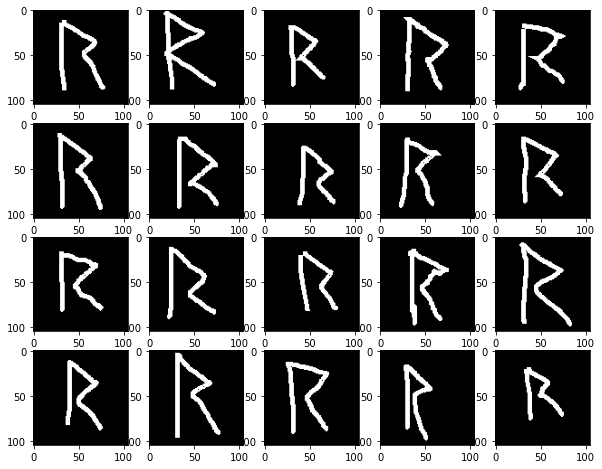

In [5]:
import os
import random as rdm
from sys import platform as sys_pf
import matplotlib
if sys_pf == 'darwin':
    matplotlib.use("TkAgg")
from matplotlib import pyplot as plt

%matplotlib inline

def num2str(idx):
    if idx < 10:
        return '0'+str(idx)
    return str(idx)

def load_img(fn):
    I = plt.imread(fn)
    I = np.array(I,dtype=bool)
    return I

rdm.seed(7)

img_dir = '/Users/James/Dropbox/James MacBook/Guillaume/omniglot/omniglot/python/images_background'
nreps = 20 # number of renditions for each character
nalpha = 1 # number of alphabets to show

alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names
alphabet_names = rdm.sample(alphabet_names,nalpha) # choose random alphabets

training_data = onp.empty((nreps, 105, 105))

for a in range(nalpha): # for each alphabet
    # print('generating figure ' + str(a+1) + ' of ' + str(nalpha))
    alpha_name = alphabet_names[a]

    # choose a random character from the alphabet
    character_id = rdm.randint(1,len(os.listdir(os.path.join(img_dir,alpha_name))))

    # get image and stroke directories for this character
    img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(character_id))

    # get base file name for this character
    fn_example = os.listdir(img_char_dir)[0]
    fn_base = fn_example[:fn_example.find('_')] 

    plt.figure(a,figsize=(10,8))
    for r in range(1,nreps+1): # for each rendition
        plt.subplot(4,5,r)
        fn_img = img_char_dir + '/' + fn_base + '_' + num2str(r) + '.png'
        I = load_img(fn_img) == False # This ensures letter pixels are 1
        training_data[r-1,:,:] = I
        plt.imshow(I, cmap='gray')
plt.show()
# plt.close()
training_data = np.array(training_data)

In [6]:
# explicitly generate a PRNG key
seed = 0
key = random.PRNGKey(seed)

# generate the required number of subkeys
key, subkeys = keyGen(key, n_subkeys = 4)    

n_examples = 1
image_height = 105
image_width = 105
# training_data = random.bernoulli(random.PRNGKey(1), 0.5, (n_examples, image_height, image_width)).astype(float)
# training_data = random.normal(random.PRNGKey(1), (n_examples, image_height, image_width)).astype(float)
# training_data = (training_data - np.min(training_data)) / (np.max(training_data) - np.min(training_data))
# n_examples = 2
# validation_data = random.bernoulli(random.PRNGKey(1), 0.5, (n_examples, image_height, image_width)).astype(float)
validation_data = training_data

# primary hyperparameters
hyperparams = {'image_dim': np.array(training_data.shape[1:]),
               'x_dim': [20, 50, 200],
               'alpha_fraction': 0.1,
               'time_steps': 100,
               'dt': 0.1,
               'var_min': 1e-16,
               'smooth_max_parameter': 1000}

# secondary hyperparameters (derived from primary hyperparameters)
hyperparams['n_loops'] = [int(np.ceil(i * hyperparams['alpha_fraction'])) for i in hyperparams['x_dim']]
hyperparams['x_pixels'] = np.linspace(0.5, hyperparams['image_dim'][1] - 0.5, hyperparams['image_dim'][1])
hyperparams['y_pixels'] = np.linspace(0.5, hyperparams['image_dim'][0] - 0.5, hyperparams['image_dim'][0])
# hyperparams['S_rank'] = [int(np.ceil(i * hyperparams['S_rank_fraction'])) for i in hyperparams['x_dim']]

encoder = CNN(n_loops_top_layer = hyperparams['n_loops'][0], x_dim_top_layer = hyperparams['x_dim'][0])
readout = pen_actions_readout()
models = (encoder, readout)

init_params = {}
init_params['encoder'] = encoder.init(x = np.ones((1, training_data.shape[1], training_data.shape[2], 1)), 
                                      rngs = {'params': next(subkeys)})
init_params['prior_z_log_var'] = np.log(0.1)
init_params['dynamics'] = initialise_dynamics_parameters(hyperparams, next(subkeys))
init_params['readout'] = readout.init(x = np.ones((hyperparams['x_dim'][-1])), rngs = {'params': next(subkeys)})
init_params['pen_log_var'] = 10.0
# init_params['prior'] = {'log_noise_var': np.log(0.1) * np.ones((hyperparams['n_loops'][0],))}

x0 = initialise_hidden_states(hyperparams)

optimisation_hyperparams = {'kl_warmup_start': 500,
                            'kl_warmup_end': 1000,
                            'kl_min': 0.01,
                            'kl_max': 1,
                            'step_size': 0.001,
                            'decay_steps': 1,
                            'decay_factor': 0.9999,
                            'adam_b1': 0.9,
                            'adam_b2': 0.999,
                            'adam_eps': 1e-1,
                            'weight_decay': 0.0001,
                            'max_grad_norm': 10,
                            'batch_size': 5,
                            'print_every': 1,
                            'n_epochs': 2}
optimisation_hyperparams['n_batches'] = int(training_data.shape[0] / optimisation_hyperparams['batch_size'])

In [7]:
# # A = construct_dynamics_matrix(init_params, hyperparams)

# layer = 0
# x = onp.random.randn(A[layer].shape[-1])
# alphas = onp.array([0.5, 0.5])
# xnext = []
# for i in range(1000):
#     # x = x + np.sum(alphas[:,None,None] * A[layer], axis = 0) @ x * 0.1
#     xnext.append(x + np.mean(A[layer], axis = 0) @ x * 0.1)
    
# plt.hist(np.reshape(np.stack(xnext),(1000*20,)))
# # np.real(np.linalg.eigvals(A[layer]))>0
# # (np.sum(alphas[:,None,None] * A[layer], axis = 0)@ x).shape

# # x_new = jax.tree_map(lambda A, x, alphas, u: x + (np.sum(alphas[:, None, None] * A, axis = 0) @ x + u) * hyperparams['dt'], A, x, alphas, u)
# # from matplotlib import pyplot as plt
# # plt.figure
# # np.sum(init_params['dynamics']['L'][2] @ np.transpose(init_params['dynamics']['L'][2], (0,2,1)),axis=0)[0,0]
# # S = jax.tree_map(lambda U, V: U @ np.transpose(V, (0, 2, 1)) - V @ np.transpose(U, (0, 2, 1)), 
# #                  init_params['dynamics']['S_U'], init_params['dynamics']['S_V'])
# # S = jax.tree_map(lambda S, n: S / np.linalg.norm(S, axis = (1, 2))[:, None, None] / n, 
# #                  S, hyperparams['n_loops'])
# # S[2].shape
# # np.std(S[0], axis = (1,2))
# # S = jax.tree_map(lambda U, V: U @ np.transpose(V, (0, 2, 1)) - V @ np.transpose(U, (0, 2, 1)), 
#                  # init_params['dynamics']['S_U'], init_params['dynamics']['S_V'])
# # S = jax.tree_map(lambda S, n: S / np.linalg.norm(S, axis = (1, 2))[:, None, None] / n, 
# #                  S, hyperparams['n_loops'])
# # S = jax.tree_map(lambda S, n: S / np.std(S, axis = (1, 2))[:, None, None] / np.sqrt(n * S.shape[-1]), 
#                  # S, hyperparams['n_loops'])
# # np.var(S[2]/np.std(S[2])/5)
# # plt.hist(np.reshape(S[2],(1,200*20*200)),1000)
# # plt.show()
# # layer = 1
# # x = onp.random.randn(A[layer].shape[-1])
# # alphas = onp.array([0.5, 0.5])
# # for i in range(10000):
# #     # x = x + np.sum(alphas[:,None,None] * A[layer], axis = 0) @ x * 0.1
# #     x = x + np.mean(A[layer], axis = 0) @ x * 1
# # x
# # np.real(np.linalg.eigvals(A[layer]))>0
# # (np.sum(alphas[:,None,None] * A[layer], axis = 0)@ x).shape

In [10]:
def kl_scheduler(optimisation_hyperparams):
    
    kl_warmup_start = optimisation_hyperparams['kl_warmup_start']
    kl_warmup_end = optimisation_hyperparams['kl_warmup_end']
    kl_min = optimisation_hyperparams['kl_min']
    kl_max = optimisation_hyperparams['kl_max']
    n_batches = optimisation_hyperparams['n_batches']
    
    kl_schedule = []
    for i_batch in range(n_batches):
        
        warm_up_fraction = min(max((i_batch - kl_warmup_start) / (kl_warmup_end - kl_warmup_start),0),1)
        
        kl_schedule.append(kl_min + warm_up_fraction * (kl_max - kl_min))

    return np.array(kl_schedule)

def reshape_training_data(training_data):
    
    return np.reshape(training_data, (optimisation_hyperparams['n_batches'],
                                      optimisation_hyperparams['batch_size'],
                                      training_data.shape[1],
                                      training_data.shape[2]))

def optimize_dynamical_VAE_core(params, x0, hyperparams, models, training_data, validation_data, optimizer, optimizer_state, 
                                optimisation_hyperparams, kl_schedule, print_every, epoch, scheduler, key):
    
    n_batches = optimisation_hyperparams['n_batches']
    
    # generate subkeys
    key, training_subkeys = keyGen(key, n_subkeys = n_batches)
    key, validation_subkeys = keyGen(key, n_subkeys = int(n_batches / print_every))
    
    # initialise the losses and the timer
    training_loss = 0
    training_losses = {'total': 0, 'cross_entropy': 0, 'kl_z': 0, 'kl_z_prescale': 0}
    start_time = time.time()

    # loop over batches
    for i in range(n_batches):
        
        i_batch = i + epoch * n_batches

        kl_weight = kl_schedule[i_batch]
        
        (loss, all_losses), grad = training_loss_grad(params, hyperparams, models, training_data[i],
                                                      x0, hyperparams['time_steps'], kl_weight, next(training_subkeys)) 

        updates, optimizer_state = optimizer.update(grad, optimizer_state, params)

        params = optax.apply_updates(params, updates)
        
        # training losses (average of 'print_every' batches)
        training_loss += loss / print_every
        training_losses = tree_map(lambda x, y: x + y / print_every, training_losses, all_losses)
        
        if (i + 1) % print_every == 0:
        
            # calculate loss on validation data
            _, validation_losses = losses_jit(params, hyperparams, models, validation_data, x0, 
                                              hyperparams['time_steps'], kl_weight, next(validation_subkeys))
            
            # end batches timer
            batches_duration = time.time() - start_time

            # print and store losses
            s1 = '\033[1m' + "Batches {}-{} in {:.2f} seconds, step size: {:.5f}" + '\033[0m'
            s2 = """  Training losses {:.4f} = cross entropy {:.4f} + KL {:.4f}, {:.4f}"""
            s3 = """  Validation losses {:.4f} = cross entropy {:.4f} + KL {:.4f}, {:.4f}"""
            print(s1.format(i + 1 - print_every + 1, i + 1, batches_duration, scheduler(i_batch)))
            print(s2.format(training_losses['total'], training_losses['cross_entropy'],
                            training_losses['kl_z'], training_losses['kl_z_prescale']))
            print(s3.format(validation_losses['total'], validation_losses['cross_entropy'],
                            validation_losses['kl_z'], validation_losses['kl_z_prescale']))

            if (i + 1) == print_every:
                tlosses_thru_training = copy(training_losses)
                vlosses_thru_training = copy(validation_losses)
            else:
                tlosses_thru_training = tree_map(lambda x, y: np.append(x, y), tlosses_thru_training, training_losses)
                vlosses_thru_training = tree_map(lambda x, y: np.append(x, y), vlosses_thru_training, validation_losses)
            
            # re-initialise the losses and the timer
            training_loss = 0
            training_losses = {'total': 0, 'cross_entropy': 0, 'kl_z': 0, 'kl_z_prescale': 0}
            start_time = time.time()
            
    losses = {'tlosses' : tlosses_thru_training, 'vlosses' : vlosses_thru_training}

    return params, optimizer_state, losses

def optimize_dynamical_VAE(params, x0, hyperparams, models, training_data, validation_data, 
                           optimisation_hyperparams, key, ckpt_dir):

    kl_schedule = kl_scheduler(optimisation_hyperparams)
    
    scheduler = optax.exponential_decay(optimisation_hyperparams['step_size'], 
                                        optimisation_hyperparams['decay_steps'], 
                                        optimisation_hyperparams['decay_factor'])

    optimizer = optax.chain(optax.adamw(learning_rate = scheduler, 
                            b1 = optimisation_hyperparams['adam_b1'],
                            b2 = optimisation_hyperparams['adam_b2'],
                            eps = optimisation_hyperparams['adam_eps'],
                            weight_decay = optimisation_hyperparams['weight_decay']),
                            optax.clip_by_global_norm(optimisation_hyperparams['max_grad_norm']))
    
    optimizer_state = optimizer.init(params)
    
    # reshape training data
    training_data = reshape_training_data(training_data)
    
    # log_folder = "runs/exp6/"
    # writer = SummaryWriter(log_folder) # flush_secs=120 by default
    
    # loop over epochs
    n_epochs = optimisation_hyperparams['n_epochs']
    print_every = optimisation_hyperparams['print_every']
    losses = {}
    for epoch in range(n_epochs):
        
        # start epoch timer
        epoch_start_time = time.time()
        
        # generate subkeys
        key, subkeys = keyGen(key, n_subkeys = 2)
        
        # shuffle the batches every epoch
        data = random.permutation(next(subkeys), training_data, axis = 0)
        
        # perform optimisation
        params, optimizer_state, losses['epoch ' + str(epoch + 1)] = \
        optimize_dynamical_VAE_core(params, x0, hyperparams, models, data, validation_data, optimizer, optimizer_state, 
                                    optimisation_hyperparams, kl_schedule, print_every, epoch, scheduler, next(subkeys))
        
        # end epoch timer
        epoch_duration = time.time() - epoch_start_time
        
        s = '\033[1m' + "\nEpoch {} in {:.1f} minutes\n" + '\033[0m'
        print(s.format(epoch + 1, epoch_duration / 60))

        # save a checkpoint
        ckpt = {'params': params, 'optimizer_state': optimizer_state, 'losses': losses}
        checkpoints.save_checkpoint(ckpt_dir = ckpt_dir, target = ckpt, step = epoch)
        
#         # log scalar metrics for tensorboard
#         writer.add_scalar('Loss/train', onp.array(training_losses['total']), epoch)
#         writer.add_scalar('Loss/validation', onp.array(validation_losses['total']), epoch)
            
    return params, optimizer_state, losses

In [11]:
from jax.config import config
config.update("jax_debug_nans", False)
config.update("jax_disable_jit", False)

ckpt_dir = 'tmp/flax-checkpointing'

import shutil
if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

# # # https://www.machinelearningnuggets.com/how-to-use-tensorboard-in-flax/
# https://www.tensorflow.org/tensorboard/get_started
# # # https://pytorch.org/docs/stable/tensorboard.html
# # # !pip install tensorboard

trained_params, optimizer_state, losses = \
optimize_dynamical_VAE(init_params, x0, hyperparams, models, training_data, validation_data, 
                       optimisation_hyperparams, key, ckpt_dir)

# ckpt = {'params': trained_params, 'optimizer_state': optimizer_state, 'losses': losses}
# restored_state = checkpoints.restore_checkpoint(ckpt_dir = ckpt_dir, target = ckpt)

# %load_ext tensorboard
# %tensorboard --logdir=runs/exp6/

# !pip install -U tensorboard-plugin-profile # for profiling
# from torch.utils.tensorboard import SummaryWriter
# log_folder = "runs/exp9/profile"
# writer = SummaryWriter(log_folder)

# jax.profiler.start_trace(log_folder)
# trained_params, opt_details, writer = \
# optimize_dynamical_VAE(init_params, x0, hyperparams, models, training_data, validation_data, 
#                        optimisation_hyperparams, key, writer)
# jax.profiler.stop_trace()
# %load_ext tensorboard
# %tensorboard --logdir=runs/exp9/profile
# NB jax only works with 'trace_viewer' plugin under Tools

# block_until_ready()

Batches 1-1 in 7.92 seconds, step size: 0.00100
  Training losses 7238.1353 = cross entropy 7237.4009 + KL 0.7345, 73.4509
  Validation losses 7235.4341 = cross entropy 7234.7104 + KL 0.7237, 72.3699
Batches 2-2 in 8.41 seconds, step size: 0.00100
  Training losses 7232.4209 = cross entropy 7231.6987 + KL 0.7226, 72.2595
  Validation losses 7230.9102 = cross entropy 7230.1968 + KL 0.7130, 71.2964
Batches 3-3 in 6.12 seconds, step size: 0.00100
  Training losses 7231.6699 = cross entropy 7230.9546 + KL 0.7150, 71.5044
  Validation losses 7226.3809 = cross entropy 7225.6782 + KL 0.7024, 70.2388
Batches 4-4 in 6.69 seconds, step size: 0.00100
  Training losses 7230.5762 = cross entropy 7229.8735 + KL 0.7024, 70.2420
  Validation losses 7221.8647 = cross entropy 7221.1694 + KL 0.6953, 69.5350

Epoch 1 in 0.5 minutes

Batches 1-1 in 7.36 seconds, step size: 0.00100
  Training losses 7226.0967 = cross entropy 7225.4023 + KL 0.6940, 69.4044
  Validation losses 7217.3628 = cross entropy 7216.6

In [ ]:
# # run model and plot
# T = 100
# data = training_data

# A = construct_dynamics_matrix(trained_params, hyperparams)

# n_examples = data.shape[0]
# subkeys = random.split(key, n_examples)
# results = batch_dynamical_VAE(trained_params, hyperparams, models, data, A, x0, T, subkeys)
# results['pen_down_log_p'].shape
# for ex in range(1):
#     plt.scatter(results['pen_xy'][ex][:,0],results['pen_xy'][ex][:,1], c = 'k', alpha =  np.exp(results['pen_down_log_p'][ex,:]))
# plt.ylim(0,105)
# plt.xlim(0,105)
# plt.show()